# Building A Model

### CHANGE LOG

Things I've done that haven't worked so well:

1. Tried OHE all the categorical variables
2. Tried linear XGB
3. Combined pool columns, don't do this, the number columns actually mean different things


Iteration 4:
- trying ditching ID columns from current best and OHE on flag columns

Iteration 5:
- Keeping ID columns, OHE flag columns

Iteration 6:
- Trying sklearn stacking

[Current Best](#currentbest) = iteration 5


TO TRY:

### Cleaning Up and Imputing Property Data
This is where we could do some imputation and cleaning on the property data

Things we can do to clean this data:
1. one hot encode id columns 
2. take property zoning down to one column/look into those ones
3. OHE flags
4. Drop latitude/longitude columns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import xgboost as xgb
import gc
from stackerr import stacking_ensemble

from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

color = sns.color_palette()

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
prop = pd.read_csv("./properties_2016.csv")
train = pd.read_csv("./train_2016.csv")
sample_sub = pd.read_csv("./sample_submission.csv")

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
xls = pd.ExcelFile("./zillow_data_dictionary.xlsx")
names = xls.sheet_names
dd_dict = {name.lower().replace(" ", "_"): xls.parse(name) for name in names}

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90811 entries, 0 to 90810
Data columns (total 3 columns):
parcelid           90811 non-null int64
logerror           90811 non-null float64
transactiondate    90811 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [4]:
for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float64)

In [55]:
dd_dict.keys()

[u'data_dictionary',
 u'typeconstructiontypeid',
 u'propertylandusetypeid',
 u'storytypeid',
 u'buildingclasstypeid',
 u'heatingorsystemtypeid',
 u'airconditioningtypeid',
 u'architecturalstyletypeid']

<a id='current'></a>

### CURRENTLY TESTING

In [2]:
## READING IN AND PREPPING DATA

print( "\nreading files ...")
properties = pd.read_csv('./properties_2016.csv')
train = pd.read_csv("./train_2016.csv")

##### PROCESS DATA
impute = Imputer(strategy='median')

flag_columns = ['hashottuborspa', 'fireplaceflag']

print( "\Imputing Medians ...")
for c in properties.columns:
    if properties[c].dtype == 'float64' and 'id' not in c and 'flag' not in c and c not in flag_columns:
        properties[c] = impute.fit_transform(properties[[c]])


reading files ...


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


\Imputing Medians ...


In [3]:
# OHE Flag columns
properties['taxdelinquencyflag'] = [1 if val == 'Y' else 0 for val in properties['taxdelinquencyflag'].values]
flag_columns = ['hashottuborspa', 'fireplaceflag']
for c in flag_columns:
    properties[c] = [1 if val == True else 0 for val in properties[c]]

drop_columns = ['parcelid', 'logerror','transactiondate','propertyzoningdesc', 
                         'propertycountylandusecode', 'fireplacecnt']
id_columns = [c for c in properties.columns if 'id' in c]
drop_columns += id_columns

prop_drop_columns = list(drop_columns)
prop_drop_columns.remove('logerror')
prop_drop_columns.remove('transactiondate')

# create train_df and drop out ouliers
train_df = train.merge(properties, how='left', on='parcelid')

train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.419 ]

In [7]:
# MAKING TEST/TRAIN MATRICES
x_train = train_df.drop(drop_columns, axis=1)
x_submission = properties.drop(prop_drop_columns, axis=1)

y = train_df["logerror"].values.astype(np.float32)

print 'scaling training data'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)
x_submission = scaler.fit_transform(x_submission)

print 'train test splitting'
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.05, random_state=25)

scaling training data
train test splitting


In [ ]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

print 'training stacking regressor'

rfr_1 = RandomForestRegressor(n_estimators=200, criterion='mae', max_depth=6)
rfr_2 = RandomForestRegressor(n_estimators=200, criterion='mae', max_depth=5)
gbr_1 = GradientBoostingRegressor(n_estimators=200, criterion='mae', max_depth=5, alpha=.8, learning_rate=.037,
                                  subsample=.8)
gbr_2 = GradientBoostingRegressor(n_estimators=200, criterion='mae', max_depth=6, alpha=.8, learning_rate=.03,
                                  subsample=.8)
svr = SVR(kernel='rbf')
ridge = Ridge(alpha=0.4)
lasso = Lasso(alpha=0.8)

gbr_3 = GradientBoostingRegressor(n_estimators=200, criterion='mae', max_depth=3, alpha=.4, learning_rate=.1,
                                  subsample=.8)

stacking_ens = stacking_ensemble(base_models=[svr, ridge, lasso, gbr_1, gbr_2], 
                   stacking_model=gbr_3)

stacking_ens.fit(X_train, y_train)

training stacking regressor
fitting base models
---> Fitting fold  1.0
------> Fitting model  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
------> Fitting model  Ridge(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
------> Fitting model  Lasso(alpha=0.8, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
------> Fitting model  GradientBoostingRegressor(alpha=0.8, criterion='mae', init=None,
             learning_rate=0.037, loss='ls', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
     

In [10]:
# Evaluate and visualize the fit

print "Mean Absolute Error: %.4f" % mean_absolute_error(y_test, stacking_ens.predict(X_test))
# print('Variance Score: %.4f' % stac.score(X_scaled, y))

Mean Absolute Error: 0.0533


In [11]:
y_pred = stacking_ens.predict(x_submission)

In [12]:
submission = pd.read_csv("./sample_submission.csv")

# We're just going to make the prediction for each month the same
for c in submission.columns:
    if c != 'ParcelId':
        submission[c] = y_pred

submission.to_csv("stacking_submission.csv", index=False, float_format='%.4f')

<a id='currentbest'></a>

# CURRENT BEST

In [70]:
##### RE-READ PROPERTIES FILE
##### (I tried keeping a copy, but the program crashed.)

print( "\nRe-reading properties file ...")
properties = pd.read_csv('./properties_2016.csv')

##### PROCESS DATA FOR XGBOOST

print( "\nProcessing data for XGBoost ...")
for c in properties.columns:
    properties[c]=properties[c].fillna(-1)
    if properties[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties[c].values))
        properties[c] = lbl.transform(list(properties[c].values))

# OHE Flag columns
properties['taxdelinquencyflag'] = [1 if val == 'Y' else 0 for val in properties['taxdelinquencyflag'].values]
flag_columns = ['hashottuborspa', 'fireplaceflag']
for c in flag_columns:
    properties[c] = [1 if val == True else 0 for val in properties[c]]

drop_columns = ['parcelid', 'logerror','transactiondate','propertyzoningdesc', 
                         'propertycountylandusecode', 'fireplacecnt']

prop_drop_columns = list(drop_columns)
prop_drop_columns.remove('logerror')
prop_drop_columns.remove('transactiondate')

# create train_df and drop out ouliers
train_df = train.merge(properties, how='left', on='parcelid')

train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.419 ]

# MAKING TEST/TRAIN MATRICES
x_train = train_df.drop(drop_columns, axis=1)
x_test = properties.drop(prop_drop_columns, axis=1)
y_train = train_df["logerror"].values.astype(np.float32)
y_mean = np.mean(y_train)

print('After removing outliers:')     
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))


##### RUN XGBOOST

print("\nSetting up data for XGBoost ...")
# xgboost params
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

num_boost_rounds = 250
print("num_boost_rounds="+str(num_boost_rounds))

# train model
print( "\nTraining XGBoost ...")
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

print( "\nPredicting with XGBoost ...")
xgb_pred1 = model.predict(dtest)

print( "\nFirst XGBoost predictions:" )
print( pd.DataFrame(xgb_pred1).head() )

In [52]:
submission = pd.read_csv("./sample_submission.csv")

# We're just going to make the prediction for each month the same
for c in submission.columns:
    if c != 'ParcelId':
        submission[c] = xgb_pred1

submission.to_csv("xgboost_LAME_submission.csv", index=False, float_format='%.4f')

In [6]:
# Let's see what's going on with the object collumns in the data.

for c in train_df.dtypes[train_df.dtypes == 'object'].index.values:
    print train_df[c].value_counts()[0:5]
    print '------'

2016-04-29    917
2016-07-29    912
2016-09-30    900
2016-06-30    878
2016-05-27    876
Name: transactiondate, dtype: int64
------
True    2365
Name: hashottuborspa, dtype: int64
------
0100    30846
122     15383
010C    10264
0101     7435
34       5946
Name: propertycountylandusecode, dtype: int64
------
LAR1       7678
LAR3       2801
LARS       1503
LBR1N      1459
LARD1.5    1305
Name: propertyzoningdesc, dtype: int64
------
True    222
Name: fireplaceflag, dtype: int64
------
Y    1783
Name: taxdelinquencyflag, dtype: int64
------


//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 12:00:32.684387. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


For now we'll just drop the object columns that aren't binary, and we'll change the binary to boolean Trues because they're just flags.

In [7]:
x_train = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'],
                       axis = 1)

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 12:00:32.775265. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
x_train['taxdelinquencyflag'].value_counts()

Y    1783
Name: taxdelinquencyflag, dtype: int64

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 12:00:32.899732. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
object_columns = x_train.dtypes[x_train.dtypes == 'object'].index.values.tolist()
object_columns.remove('taxdelinquencyflag')
for c in object_columns:
    print 'column: ', c
    x_train[c] = [1 if val == True else 0 for val in x_train[c]]

x_train['taxdelinquencyflag'] = [1 if val == 'Y' else 0 for val in x_train['taxdelinquencyflag'].values]

for c in x_train.columns:
    x_train[c] = x_train[c].astype(np.float64)

column:  hashottuborspa
column:  fireplaceflag


//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 12:00:32.924268. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Let's go ahead and ditch any column that is an "id" of some kind, we'll add these to a list to one hot encode later

In [57]:
columns = x_train.columns

id_columns = []
for element in columns:
    m = re.match("\w+id$", element)
    if m:
        id_columns.append(element)

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 13:03:55.568010. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [58]:
x_train = x_train.drop(id_columns, axis = 1)

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 13:03:56.252746. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [59]:
y_train = train_df['logerror'].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.1, random_state=25)

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)

# saving train columns for use later when we prepare the testing data

train_columns = x_train.columns

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 13:03:56.828990. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Boosted Tree Model

In [64]:
params = {
    'eta': 0.02,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 4,
    'silent': 1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, num_boost_round=10000, evals=watchlist, early_stopping_rounds=100,
                verbose_eval=10)

[0]	train-mae:0.48819	valid-mae:0.48711
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.402317	valid-mae:0.401478
[20]	train-mae:0.332754	valid-mae:0.33219
[30]	train-mae:0.276581	valid-mae:0.276345
[40]	train-mae:0.231378	valid-mae:0.231488
[50]	train-mae:0.195135	valid-mae:0.195575
[60]	train-mae:0.166209	valid-mae:0.167009
[70]	train-mae:0.143215	valid-mae:0.144424
[80]	train-mae:0.125092	valid-mae:0.126649
[90]	train-mae:0.110953	valid-mae:0.112784
[100]	train-mae:0.10003	valid-mae:0.102087
[110]	train-mae:0.091692	valid-mae:0.093957
[120]	train-mae:0.085415	valid-mae:0.087879
[130]	train-mae:0.080761	valid-mae:0.083394
[140]	train-mae:0.077346	valid-mae:0.080127
[150]	train-mae:0.074846	valid-mae:0.077765
[160]	train-mae:0.073038	valid-mae:0.076067
[170]	train-mae:0.071722	valid-mae:0.074844
[180]	train-mae:0.07077	valid-mae:0.073973
[190]	train-mae:0.070081	valid-mae:0

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 13:04:20.364380. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Boosted Linear Model

In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 14:04:36.626049. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.1, random_state=25)

In [88]:
linear_params = {
    'lambda': .2,
    'alpha': 1,
    'lambda_bias': .1,
    'eval_metric': 'mae',
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
linear_xgb = xgb.train(linear_params, d_train, num_boost_round=10000, evals=watchlist, early_stopping_rounds=50,
                verbose_eval=10)

[0]	train-mae:0.354364	valid-mae:0.353725
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[10]	train-mae:0.069463	valid-mae:0.073554
[20]	train-mae:0.067204	valid-mae:0.072441
[30]	train-mae:0.066688	valid-mae:0.072788
[40]	train-mae:0.066214	valid-mae:0.07313
[50]	train-mae:0.065799	valid-mae:0.073367
[60]	train-mae:0.065346	valid-mae:0.0738
Stopping. Best iteration:
[16]	train-mae:0.067542	valid-mae:0.072187



//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 13:41:31.106697. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Plotting Model Residuals

In [102]:
# first we'll look at the linear model residuals

all_x_d = xgb.DMatrix(x_train)
linear_pred_train = linear_xgb.predict(all_x_d)

residuals = linear_pred_train - train_df['logerror'].values

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 13:52:21.791739. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


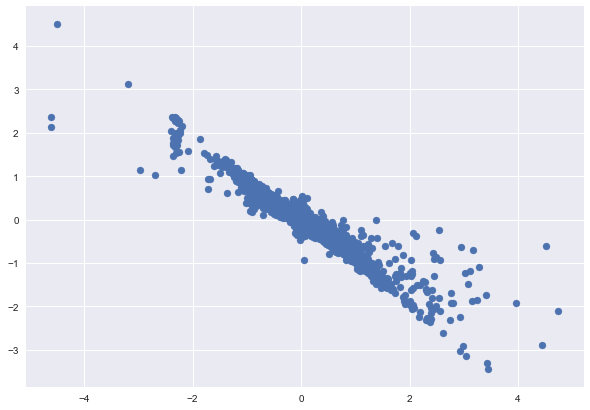

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 13:53:54.601849. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [106]:
plt.figure(figsize=(10,7))
plt.scatter(x=train_df['logerror'], y=residuals)

There's clearly a lot of bias in this model, estimated guesses are not able to account for extremes on either end, it looks like we're underguessing on large values and overguessing on small values.

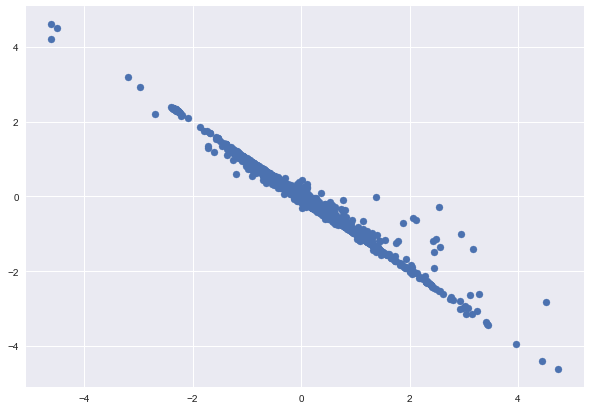

//anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-08-28 13:58:46.783745. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [108]:
# now let's look at the tree model residuals

tree_pred_train = clf.predict(all_x_d)

tree_residuals = tree_pred_train - train_df['logerror'].values
plt.figure(figsize=(10,7))
plt.scatter(x=train_df['logerror'], y=tree_residuals)

In [ ]:
### LEGACY CODE


#### GET DUMMY COLUMNS FOR TRAIN
#### THIS IS BAD BECAUSE WE NEED TO DO IT FOR THE WHOLE PROPERTY DATA SET TO USE IT IN FINAL MODEL

# id_columns = [c for c in train_df.columns if 'id' in c]
# id_columns.remove('parcelid')

# print 'getting dummies...'
# for c in id_columns:
#     column_data = pd.get_dummies(train_df[c])
#     column_data.rename(columns={col: str(c) + "_" + str(col) for col in column_data.columns}, inplace=True)
#     train_df[column_data.columns] = column_data

# print "dropping null rows"
# for c in train_df.columns:
#     if str(null_id) in c:
#         del(train_df[c])

In [ ]:
# Going to impute the median for all of the continuous columns

from sklearn.preprocessing import Imputer

cont_columns = [c for c in train_df.columns if 'id' not in c]
cont_columns.remove('taxdelinquencyflag')
cont_columns.remove('hashottuborspa')
cont_columns.remove('fireplaceflag')
cont_columns.remove('logerror')
cont_columns.remove('transactiondate')
cont_columns.remove('censustractandblock')
cont_columns.remove('propertycountylandusecode')
cont_columns.remove('propertyzoningdesc')

impute = Imputer(strategy='median', axis=0)

for c in cont_columns:
    train_df[c] = impute.fit_transform(train_df[[c]])

# DROPPING REALLY LOW COUNT COLUMNS

for c in train_df.columns:
    if train_df[c].count() <= 800:
        del(train_df[c])

null_id = 1234

print 'filling nulls...'
for c in id_columns:
    train_df[c] = train_df[c].fillna(null_id)